<a href="https://colab.research.google.com/github/ellagattis/kuka/blob/main/data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# kuka & magnaprobe data analysis

## initial imports & setup

In [ ]:
#pip installs i need
!pip install control
!pip install pandas
!pip install ipympl

     |████████████████████████████████| 266kB 7.7MB/s 
  Created wheel for control: filename=control-0.8.4-py2.py3-none-any.whl size=276947 sha256=c51d2d63a83448e36b74374294c956f4d80905d6319436e693648a7ebd606840
  Stored in directory: /root/.cache/pip/wheels/3e/a4/9a/8b6ad43fcb2aba7debf8188b60a3def7aaa9a11582b7929ead
Successfully built control
     |████████████████████████████████| 112kB 9.5MB/s 


In [ ]:
#imports needed
import pickle
import numpy as np
import matplotlib.pyplot as plt
import control
import math
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class kuka_magna: 

    def __init__(self, date, bandwidth, binsize):  #e.g. 20191107
        self.date = date
   
    def rfiles(self): #radar data files
       
        print('running rfiles')
        print('date: ', date)
        print('bandwidth: ', bandwidth)


       
        if bandwidth == 'full_bw':
            print('bandwidth is full_bw')
            file_path = '/content/drive/My Drive/msci_project/'
        elif bandwidth == 'cs2_alt':
            print('bandwidth is cs2_alt')
            file_path = '/content/drive/My Drive/msci_project/'
       
        print('file path: ',file_path)



#get the ship location info and correct the lat and lons
#     def sfiles(self):
        pfile_path = '/content/drive/My Drive/msci_project/'

        pos = pd.read_csv(pfile_path+'data', sep='\t',skipinitialspace=True,skiprows=1,engine='python')
        pos = pd.DataFrame(pos).to_numpy()

        ship_lat = pos[:,1]
        ship_lon = pos[:,2]
        ship_heading = pos[:,3]

        t=pos[:,0]

        year = [int(sub[0:4]) for sub in t]
        month = [int(sub[5:7]) for sub in t]
        day = [int(sub[8:10]) for sub in pos[:,0]]
        hour = [int(sub[11:13]) for sub in pos[:,0]]
        minute = [int(sub[14:16]) for sub in pos[:,0]]
        second = [int(sub[17:19]) for sub in pos[:,0]]

#         ship_dt=np.zeros(len(year))
        ship_dt=np.full(len(year), np.nan)

        for i in range(len(year)):
            t=datetime.datetime(year[i],month[i],day[i],hour[i],minute[i],second[i])
            ship_dt[i] = (t - datetime.datetime(1970,1,1)).total_seconds()

        print('ship times between:')  
        print(datetime.datetime.utcfromtimestamp(ship_dt[0]))
        print(datetime.datetime.utcfromtimestamp(ship_dt[-1]))

        #correct all data to 12 midday on the day of the observations
        ref_time = datetime.datetime(int(self.date[0:4]),int(self.date[4:6]),int(self.date[6:8]),12,0,0)

        ref = np.where(ship_dt == (ref_time - datetime.datetime(1970,1,1)).total_seconds())[0]
        print('ref',ref,ref_time)
   
   
#find radar files      

        for b in ['Ka','Ku']:
            rf = fnmatch.filter(os.listdir(file_path),b+'*'+self.date+'*'+'range_hh_vv_hv_vh.txt')    #echo files
            rf.sort()                                                               #sort for echoes list
            echo_files = rf
#             print('echo_files',echo_files)
            sf = [sub[0:23]+'.nrcs.stare' for sub in rf]                            #summary files
            igroup = [sub[31:37] for sub in rf]
            elev = [sub[46:52] for sub in rf]
           
            if b == 'Ka':
                self.ka_echo_files = np.array(rf)
                self.ka_summ_files = np.array(sf)
                self.ka_igroup = np.array(igroup)
                self.ka_elev = np.array(elev)
            elif b == 'Ku':
                self.ku_echo_files = np.array(rf)
                self.ku_summ_files = np.array(sf)
                self.ku_igroup = np.array(igroup)
                self.ku_elev = np.array(elev)    
                       
#read in the echo files
       
            for r in rf:              
                print('echo file: ', r)
                ef=pd.read_csv(file_path+r, delimiter=' ',
                                    names=['range','hh','vv','hv','vh'],skipinitialspace=True)
   
                if r == rf[0]:                                             #first one
                    print('first echo')
                    echo = pd.DataFrame(ef).to_numpy()
                else:
                    print('echo', r)
                    echo = np.vstack((echo,pd.DataFrame(ef).to_numpy()))   #stack the rest
            help(echo)            
            if b == 'Ka':    
                nsamp = 4096
                self.ka_rg=echo[:,0].reshape(len(rf),nsamp).transpose()    #make 'images' from echoes
                self.ka_hh=echo[:,1].reshape(len(rf),nsamp).transpose()    #each echo is in [:,echo_number]
                self.ka_vv=echo[:,2].reshape(len(rf),nsamp).transpose()
                self.ka_hv=echo[:,3].reshape(len(rf),nsamp).transpose()
                self.ka_vh=echo[:,4].reshape(len(rf),nsamp).transpose()
            elif b == 'Ku':
                nsamp = 2048
                self.ku_rg=echo[:,0].reshape(len(rf),nsamp).transpose()
                self.ku_hh=echo[:,1].reshape(len(rf),nsamp).transpose()
                self.ku_vv=echo[:,2].reshape(len(rf),nsamp).transpose()
                self.ku_hv=echo[:,3].reshape(len(rf),nsamp).transpose()
                self.ku_vh=echo[:,4].reshape(len(rf),nsamp).transpose()    
               
#echo files done
 
#get data from summary files

            summ = []    
            peak = np.zeros(len(rf))
            lat = np.zeros(len(rf)) ; lon = np.zeros(len(rf)) ;
            start_time = np.zeros(len(rf))
            end_time = np.zeros(len(rf)) ; st = 0 ; fin = 0
           
           
       
            for s in list(dict.fromkeys(sf)) :                                        # read in summary files
                print('s',s)      
                with open(file_path+s,'r') as summfile: summ = summfile.read().splitlines()
               
                separator = ''
                ngroups = int(summ[1])
                match = [np.array(sf) == s]
                               
                st = summ.index('range peak signal: ') + 1 #data start on next line
                fin = st + summ[st:].index('')
                peak[match] = np.fromstring(separator.join(summ[st:fin]), dtype = np.float, sep = '      ' )                  

                asumm=np.array(summ)

                lat[match] = asumm[np.where(asumm == 'mean latitude: ')[0]+1]
                lon[match] = asumm[np.where(asumm == 'mean longitude: ')[0]+1]
                start_time[match] = asumm[np.where(asumm == 'start time of group: ')[0]+1]
                end_time[match] = asumm[np.where(asumm == 'end time of group: ')[0]+1]

                if b == 'Ka':
                    self.ka_peak = peak
                    self.ka_lat = lat
                    self.ka_lon = lon      
                    self.ka_start_time = start_time
                    self.ka_end_time = end_time
                elif b == 'Ku':
                    self.ku_peak = peak
                    self.ku_lat = lat
                    self.ku_lon = lon      
                    self.ku_start_time = start_time
                    self.ku_end_time = end_time
                   
#location correction using ship data
 
       
        #ka
        ka_lat_n = np.zeros(len(self.ka_start_time))
        ka_lon_n = np.zeros(len(self.ka_start_time))
        for i in range(len(self.ka_start_time)):
            before = np.where(ship_dt <= self.ka_start_time[i])
            before = before[-1]
            before = before[-1]
            after = np.where(ship_dt >= self.ka_start_time[i])
            after = after[0]
            after = after[0]
            prop = (self.ka_start_time[i] - ship_dt[before])/(ship_dt[after] - ship_dt[before])
            shift_lat = (ship_lat[after]-ship_lat[before])*prop + (ship_lat[before] - ship_lat[ref])
            ka_lat_n[i] = self.ka_lat[i] - shift_lat    
            shift_lon = (ship_lon[after]-ship_lon[before])*prop + (ship_lon[before] - ship_lon[ref])
            ka_lon_n[i] = self.ka_lon[i] - shift_lon  
        self.ka_lat_n = ka_lat_n
        self.ka_lon_n = ka_lon_n
       
        #ku
        ku_lat_n = np.zeros(len(self.ku_start_time))
        ku_lon_n = np.zeros(len(self.ku_start_time))
        for i in range(len(self.ku_start_time)):
            before = np.where(ship_dt <= self.ku_start_time[i])
            before = before[-1]
            before = before[-1]
            after = np.where(ship_dt >= self.ku_start_time[i])
            after = after[0]
            after = after[0]
            prop = (self.ku_start_time[i] - ship_dt[before])/(ship_dt[after] - ship_dt[before])
            shift_lat = (ship_lat[after]-ship_lat[before])*prop + (ship_lat[before] - ship_lat[ref])
            ku_lat_n[i] = self.ku_lat[i] - shift_lat    
            shift_lon = (ship_lon[after]-ship_lon[before])*prop + (ship_lon[before] - ship_lon[ref])
            ku_lon_n[i] = self.ku_lon[i] - shift_lon  

        self.ku_lat_n = ku_lat_n
        self.ku_lon_n = ku_lon_n

    

## some preliminary plots

In [ ]:
date = '20200116'
bandwidth = 'full_bw'
save_folder = '/content/drive/My Drive/msci_project/'
file = date+'_'+bandwidth+'.p'
test = pickle.load(open(save_folder+file, "rb"))  
print(dir(test))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'date', 'ka_echo_files', 'ka_elev', 'ka_end_time', 'ka_hh', 'ka_hv', 'ka_igroup', 'ka_lat', 'ka_lat_n', 'ka_lon', 'ka_lon_n', 'ka_peak', 'ka_rg', 'ka_start_time', 'ka_summ_files', 'ka_vh', 'ka_vv', 'ku_echo_files', 'ku_elev', 'ku_end_time', 'ku_hh', 'ku_hv', 'ku_igroup', 'ku_lat', 'ku_lat_n', 'ku_lon', 'ku_lon_n', 'ku_peak', 'ku_rg', 'ku_start_time', 'ku_summ_files', 'ku_vh', 'ku_vv', 'rfiles']


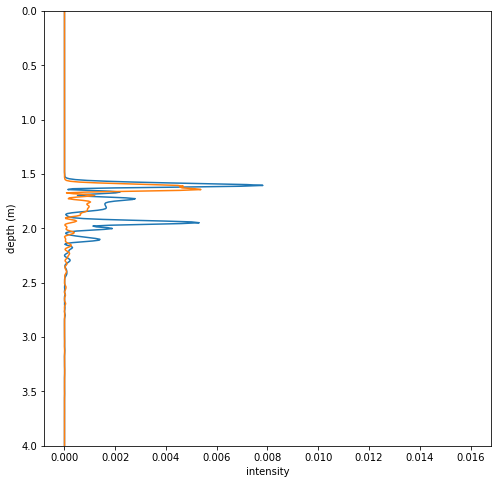

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(test.ku_hh[:,0], test.ku_rg[:,0])
plt.ylim(4,0)
plt.plot(test.ku_hh[:,1000], test.ku_rg[:,1000])
plt.xlabel('intensity')
plt.ylabel('depth (m)')
plt.show()

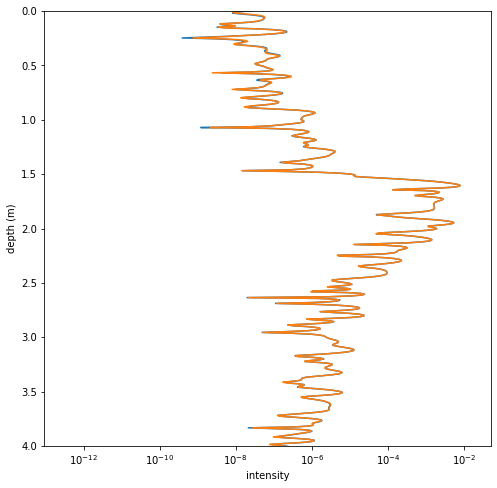

In [ ]:
plt.figure(figsize=(8,8))
plt.semilogx(test.ku_hh[:,0], test.ku_rg[:,0])
plt.semilogx(test.ku_hh[:,1], test.ku_rg[:,1])
plt.ylim(4,0)
plt.xlabel('intensity')
plt.ylabel('depth (m)')
plt.show()

In [ ]:
def find_maxima(echo,ranges):
    maxima_array = []
    ranges_array = []
    #skips first and last point because they do not have points on either side
    for i in range(1, (len(echo) - 1)):
        #only look for maxima within this depth range
        if (1.5<ranges[i]<2.5):
            if (echo[i]>echo[i-1] and echo[i]>echo[i+1]):
                maxima_array.append(echo[i])
                ranges_array.append(ranges[i])
    return maxima_array, ranges_array             

In [ ]:
maxpoints,rangevals=find_maxima(test.ku_hh[:,0],test.ku_rg[:,0])

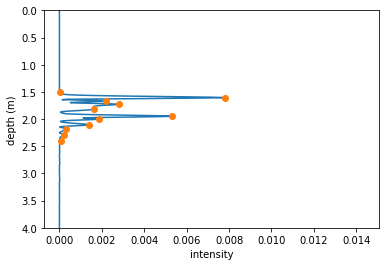

In [ ]:
plt.plot(test.ku_hh[:,0], test.ku_rg[:,0])
plt.ylim(4,0)
plt.plot(maxpoints,rangevals, "o")
plt.xlabel('intensity')
plt.ylabel('depth (m)')
plt.show()

In [ ]:
print(maxpoints)

[1.323385e-05, 0.007817956, 0.0021903245999999998, 0.0027877804, 0.0016498675, 0.0053075164, 0.0018850229999999998, 0.0013992182, 0.00031593296, 0.00022215212000000002, 9.372187e-05]


In [ ]:
#characterising the width of power spread
def power_width(echo,ranges):
    start_point = (0, 0)
    end_point = (0, 0)
    for i in range(1, (len(echo) - 1)):
        #first point that passes threshold
        if (echo[i]>(1.5e-05) and echo[i-1]<(1.5e-05)):
            start_point = (echo[i], ranges[i])
            break
    for i in range(1, (len(echo) - 1)):      
        #first point to fall below threshold
        if (echo[i]<(1.5e-05) and echo[i-1]>(1.5e-05)):
            end_point = (echo[i], ranges[i])
    return start_point, end_point

In [ ]:
start, end = power_width(test.ku_hh[:,0],test.ku_rg[:,0])

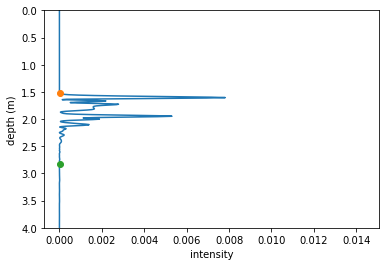

In [ ]:
plt.plot(test.ku_hh[:,0], test.ku_rg[:,0])
plt.ylim(4,0)
plt.plot(start[0], start[1], "o")
plt.plot(end[0], end[1], "o")
plt.xlabel('intensity')
plt.ylabel('depth (m)')
plt.show()

In [ ]:
print("range over", start[1], "m to ", end[1], "m")

range over 1.5286206 m to  2.8179882999999997 m


## metal plate data

In [ ]:
file_path = '/content/drive/My Drive/msci_project/metal_plate/Ka-Scat-20200107-134243_igroup_000000_line_el_000000_range_hh_vv_hv_vh.txt'
import pandas as pd
r = 'Ka-Scat-20200107-134243_igroup_000000_line_el_000000_range_hh_vv_hv_vh'
r2 = 'Ku-Scat-20200107-140435_igroup_000000_line_el_000000_range_hh_vv_hv_vh'
file_path_2 = '/content/drive/My Drive/msci_project/metal_plate/Ku-Scat-20200107-140435_igroup_000000_line_el_000000_range_hh_vv_hv_vh.txt'
s2 = 'Ku-Scat-20200107-134243_igroup_000000_line_el_000000_range_hh_vv_hv_vh.txt'
e = pd.read_csv(file_path_2, delimiter=' ', names=['range','hh','vv','hv','vh'], skipinitialspace=True)

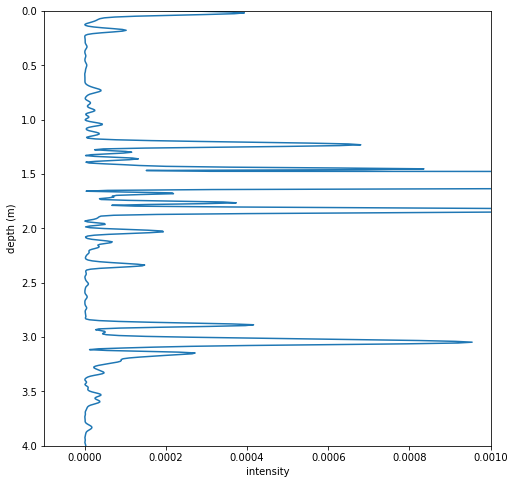

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(e.hh, e.range)
plt.ylim(4,0)
plt.xlim(-0.0001,0.001)
plt.xlabel('intensity')
plt.ylabel('depth (m)')
plt.show()

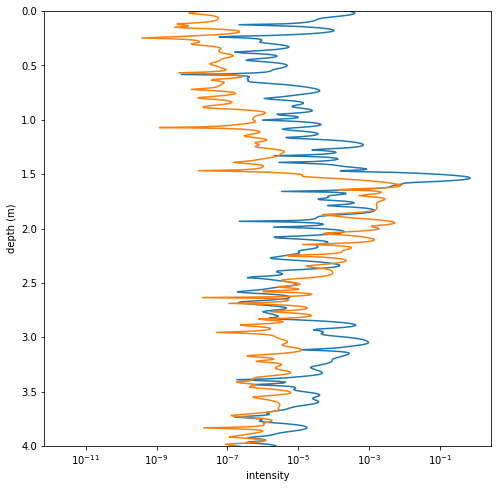

In [ ]:
plt.figure(figsize=(8,8))
plt.semilogx(e.hh, e.range)
plt.semilogx(test.ku_hh[:,0], test.ku_rg[:,0])
plt.xlabel('intensity')
plt.ylabel('depth (m)')
plt.ylim(4,0)
plt.show()

Has one main peak - far fewer reflections than echo above so I would think this is from the metal plate

In [ ]:
print(np.max(e.range))
print(np.max(e.hh))
print(np.max(e.range)/np.max(e.hh))
print(np.max(e.hh/e.range))

13.2473706
0.70536889
18.78076959135524
0.45914980634662333


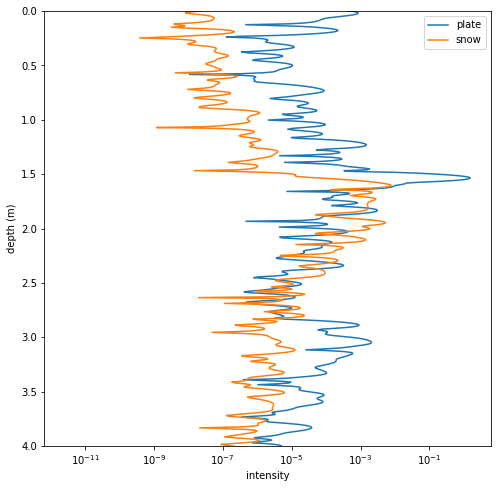

In [ ]:
plt.figure(figsize=(8,8))
plt.semilogx(e.hh/(np.max(e.hh/e.range)), e.range,label='plate')
plt.semilogx(test.ku_hh[:,0], test.ku_rg[:,0],label='snow')
plt.ylim(4,0)
plt.xlabel('intensity')
plt.ylabel('depth (m)')
plt.legend()
plt.show()

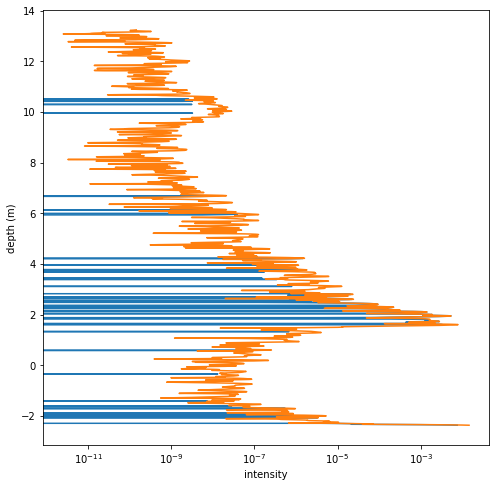

In [ ]:
plt.figure(figsize=(8,8))
plt.semilogx(test.ku_hh[:,0]-e.hh, test.ku_rg[:,0])
plt.semilogx(test.ku_hh[:,0], test.ku_rg[:,0])
plt.xlabel('intensity')
plt.ylabel('depth (m)')
plt.show()

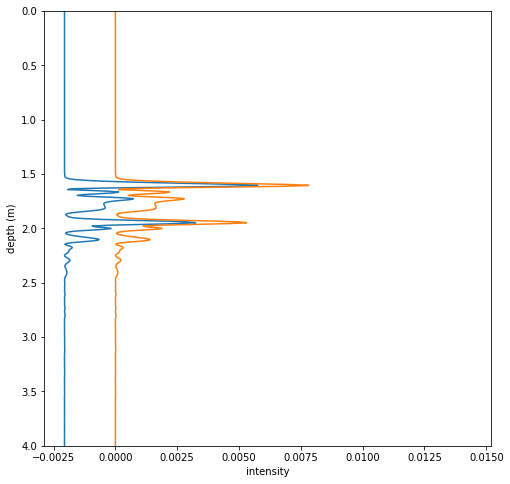

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(test.ku_hh[:,0]-e.hh[2], test.ku_rg[:,0])
plt.plot(test.ku_hh[:,0], test.ku_rg[:,0])
plt.xlabel('intensity')
plt.ylabel('depth (m)')
plt.ylim(4,0)
plt.show()

In [ ]:
from scipy import signal as sig
peaks, properties =sig.find_peaks(test.ku_hh[:,0], height = 1.5e-05)
print(peaks)
#widths, width_heights, = sig.peak_widths(test.ku_hh[:,0], peaks)

[  6 521 529 537 548 566 573 586 596 611 626 652 669 678]


In [ ]:
import fnmatch
import os
file_path = '/content/drive/My Drive/msci_project/metal_plate/'
rf = fnmatch.filter(os.listdir(file_path),'Ku*vh.txt')
rf.sort()
print(rf)

['Ku-Scat-20200107-134243_igroup_000000_line_el_000000_range_hh_vv_hv_vh.txt', 'Ku-Scat-20200107-134243_igroup_000001_line_el_000000_range_hh_vv_hv_vh.txt', 'Ku-Scat-20200107-134243_igroup_000002_line_el_000000_range_hh_vv_hv_vh.txt', 'Ku-Scat-20200107-134243_igroup_000003_line_el_000000_range_hh_vv_hv_vh.txt', 'Ku-Scat-20200107-134243_igroup_000004_line_el_000000_range_hh_vv_hv_vh.txt', 'Ku-Scat-20200107-134243_igroup_000005_line_el_000000_range_hh_vv_hv_vh.txt', 'Ku-Scat-20200107-134243_igroup_000006_line_el_000000_range_hh_vv_hv_vh.txt', 'Ku-Scat-20200107-134243_igroup_000007_line_el_000000_range_hh_vv_hv_vh.txt', 'Ku-Scat-20200107-134243_igroup_000008_line_el_000000_range_hh_vv_hv_vh.txt', 'Ku-Scat-20200107-134243_igroup_000009_line_el_000000_range_hh_vv_hv_vh.txt', 'Ku-Scat-20200107-134243_igroup_000010_line_el_000000_range_hh_vv_hv_vh.txt', 'Ku-Scat-20200107-134243_igroup_000011_line_el_000000_range_hh_vv_hv_vh.txt', 'Ku-Scat-20200107-140435_igroup_000000_line_el_000000_range_hh_

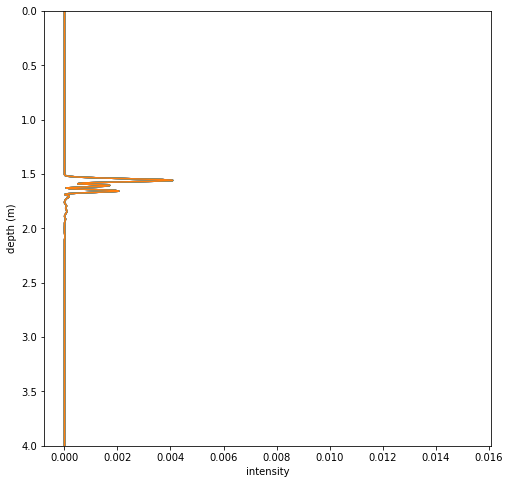

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(figsize=(8,8))
plt.ylim(4,0)
plt.xlabel('intensity')
plt.ylabel('depth (m)')

for r in rf[0:12]: 
  #print(r) 
  e = pd.read_csv(file_path+r, delimiter=' ', names=['range','hh','vv','hv','vh'],skipinitialspace=True)
  plt.plot(e.hh, e.range, label=r)

## magnaprobe data

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'date', 'ka_echo_files', 'ka_elev', 'ka_end_time', 'ka_hh', 'ka_hv', 'ka_igroup', 'ka_lat', 'ka_lat_n', 'ka_lon', 'ka_lon_n', 'ka_peak', 'ka_rg', 'ka_start_time', 'ka_summ_files', 'ka_vh', 'ka_vv', 'ku_echo_files', 'ku_elev', 'ku_end_time', 'ku_hh', 'ku_hv', 'ku_igroup', 'ku_lat', 'ku_lat_n', 'ku_lon', 'ku_lon_n', 'ku_peak', 'ku_rg', 'ku_start_time', 'ku_summ_files', 'ku_vh', 'ku_vv', 'rfiles']
mf ['PS122-2_20-95-ANJA_33_clean-20200116-UTC-0.csv', 'PS122-2_20-95-ANJA_33_cleanS-20200116-UTC-0.csv', 'PS122-2_20-95-ANJA_33_cleanN-20200116-UTC-0.csv', 'PS122-2_20-95-ANJA_33-20200116-UTC-0.csv']
mf PS122-2_20-95-ANJA_33_clean-20200116-UTC-0.csv


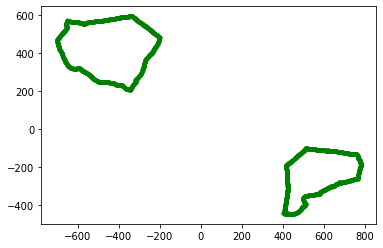

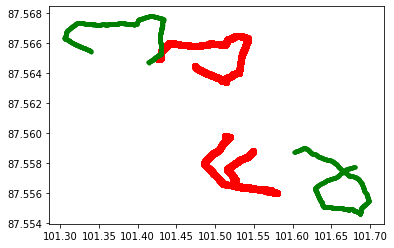

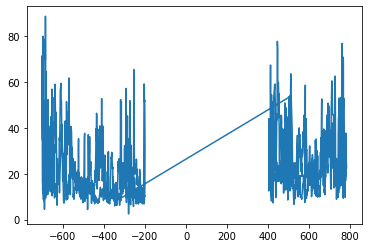

In [ ]:
save_folder = '/content/drive/My Drive/msci_project/'
#test the objects made with x and y included
date = '20200116'
file = date+'_'+bandwidth+'.p'
test = pickle.load(open(save_folder+file, "rb"))
print(dir(test))

#file2 = date+'_'+bandwidth+'_xy.p'
#test2 = pickle.load(open(save_folder+file2, "rb"))
#print(dir(test2))

mfile_path = '/content/drive/My Drive/msci_project/magna_xy/'
mf = fnmatch.filter(os.listdir(mfile_path),'*'+date+'*')
print('mf',mf)
mf = mf[0]
print('mf',mf)
mag = pd.read_csv(mfile_path+mf)

#plt.plot(test2.ku_x,test2.ku_y,'b.')
plt.plot(mag.xc,mag.yc,'g.')
plt.show()

plt.plot(test.ku_lon,test.ku_lat,'ro')
#plt.plot(test2.ku_lon,test2.ku_lat,'b.')
plt.plot(mag.lon,mag.lat,'g.')
plt.show()

plt.plot(mag.xc, mag.DepthCm)


In [ ]:
#import glob
file_path = '/content/drive/My Drive/msci_project/magna_xy/'
#rf = glob.glob("/content/drive/My Drive/msci_project/magna_xy/20200116/20200116.txt")
rf = fnmatch.filter(os.listdir(file_path),'*'+date+'*'+ '.csv')
rf.sort()
print(rf)
magna_files=[]
for r in rf:
    magna_file=pd.read_csv(file_path+r, delimiter=' ',
                                    names=['TIMESTAMP','RECORD','Counter','DepthCm','BattVolts', 'latitude_a', 'latitude_b', 
                                           'Longitude_a', 'Longitude_b', 'fix_quality', 'nmbr_satellites', 'HDOP',
                                           'altitudeB', 'DepthVolts', 'LatitudeDDDDD', 'LongitudeDDDDD', 'month', 
                                           'dayofmonth', 'hourofday', 'minutes', 'seconds', 'microseconds', 'year',
                                           'datetime_ref_1970', 'lat', 'lon', 'xc', 'yc'], skipinitialspace=True)
    magna_files.append(magna_file)

['PS122-2_20-95-ANJA_33-20200116-UTC-0.csv', 'PS122-2_20-95-ANJA_33_clean-20200116-UTC-0.csv', 'PS122-2_20-95-ANJA_33_cleanN-20200116-UTC-0.csv', 'PS122-2_20-95-ANJA_33_cleanS-20200116-UTC-0.csv']


In [ ]:
klfile_path = '/content/drive/My Drive/msci_project/kuka_locations/'
klf = fnmatch.filter(os.listdir(klfile_path),'*'+date+'*'+ '.csv')
print(klf)
ka_loc = klf[0]
ku_loc = klf[1]
ka_loc = pd.read_csv(klfile_path+ka_loc)
ku_loc = pd.read_csv(klfile_path+ku_loc)

['ka_20200116.csv', 'ku_20200116.csv']


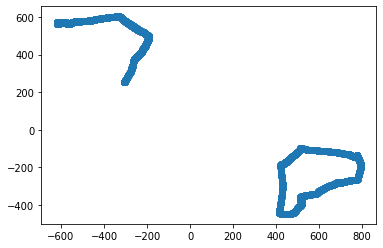

In [ ]:
plt.scatter(ku_loc.x, ku_loc.y)

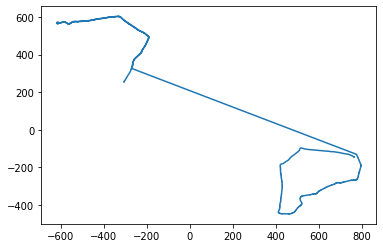

In [ ]:
plt.plot(ka_loc.x, ka_loc.y)

## nearest neighbour search

In [ ]:
#https://stackoverflow.com/questions/62400420/given-two-lists-of-2d-points-how-to-find-the-closest-point-in-the-2nd-list-for
from scipy.spatial import KDTree, cKDTree
tree = KDTree(ku_loc)
#want to create an array of just x and y coordinates of the magnaprobe
mag_loc = mag.xc, mag.yc
#query_ball_point returns all points within a radius, query returns nearest neighbours
#for every kuka point, want to find the nearest magna point - not unique?
#transpose because ku_loc has shape (2, n) so mag_loc must also have this shape
distances, indices = tree.query(np.transpose(mag_loc), k=1)
results = tree.query_ball_point(np.transpose(mag_loc), r=100)

In [ ]:
print(np.shape(ku_loc))
print(np.shape(test.ku_hh))
print(np.shape(mag_loc))
print(np.shape(indices))
print(np.shape(mag_loc)[1])

(7212, 2)
(2048, 7212)
(2, 2365)
(2365,)
2365


In [ ]:
print(np.shape(results))

(2365,)


In [ ]:
#what is k? number of nearest neighbours to search for
#code modified from https://stackoverflow.com/questions/15363419/finding-nearest-items-across-two-lists-arrays-in-python
def nearest_neighbors_kd_tree(x, y, k) :
    x, y = map(np.asarray, (x, y))
    tree = cKDTree(y)    
    ordered_neighbors = tree.query(x, k)[1]
    nearest_neighbor = np.empty((len(x),), dtype=np.intp)
    nearest_neighbor.fill(-1)
    #used_y = set()
    for j, neigh_j in enumerate(ordered_neighbors) :
        for k in neigh_j :
            #if k not in used_y :
                nearest_neighbor[j] = k
                #used_y.add(k)
                break
    return nearest_neighbor

In [ ]:
nearest_n = (nearest_neighbors_kd_tree((ku_loc), np.transpose(mag_loc), 12))
print(np.shape(nearest_n))
print(nearest_n)

(7212,)
[2128 2128 2128 ... 1274 1274 1274]


In [ ]:
def distance(point1, point2):
  x1, y1 = point1
  x2, y2 = point2

  dx = x1 - x2
  dy = y1 - y2
  return np.sqrt(dx*dx + dy*dy)

I'm not having much luck with the kdtree approach so I'm writing a manual function to find the nearest magnaprobe point for each kuka point. I'm doing this using numba to parallelize this as across CPU cores to speed it up a bit as I anticipate it being quite slow. (At the moment this doesn't work either since numba has trouble interpreting tuples), I've also used the `scipy.spatial.cdist` module which I think should be quite fast.

In [ ]:
#function to find nearest magnaprobe point to a radar point
def manual_nearest_neighbour(kuka_point, mag_locations):
  kuka_x = kuka_point.x
  kuka_y = kuka_point.y
  kuka_xy = kuka_x, kuka_y
  nearest_point = (0,0)
  n = len(mag_locations)
  for index in range(n):
    rad = distance(kuka_xy, mag_locations[index])
    if index == 0:
      min_dist = rad
      nearest_point = mag_locations[index]
      nearest_index = index
    elif (rad < min_dist):
      min_dist = rad
      nearest_point = mag_locations[index]
      nearest_index = index
  return nearest_point, nearest_index, min_dist

In [ ]:
import numba
#function to find nearest magnaprobe point to a radar point
@numba.njit(parallel=True)
def numba_nearest_neighbour(kuka_point, mag_locations):
  kuka_x, kuka_y = kuka_point
  n = len(mag_locations)
  for index in numba.prange(n):
    mag_x, mag_y = mag_locations[index]
    rad = np.float64(np.sqrt((kuka_x-mag_x)**2+(kuka_y-mag_y)**2))
    if index == 0:
      min_dist = rad
      nearest_point = mag_locations[index]
      nearest_index = index
    elif (rad < min_dist):
      min_dist = rad
      nearest_point = mag_locations[index]
      nearest_index = index
  return nearest_point, nearest_index, min_dist

In [ ]:
def compute_numba(kuka_point, mag_locations):
    result = manual_nearest_neighbour(kuka_point.to_numpy(), mag_locations)
    return result

In [ ]:
mag_nearest, index, dist = manual_nearest_neighbour(ku_loc.iloc[1000], np.transpose(mag_loc))
print(index)
print(mag.iloc[index].DepthCm)

1309
39.05


In [ ]:
print(ku_loc.iloc[1000], mag_nearest, dist)

x    486.132533
y   -133.008430
Name: 1000, dtype: float64 [ 484.98314708 -130.4318741 ] 2.8212988007112934


(4.0, 0.0)

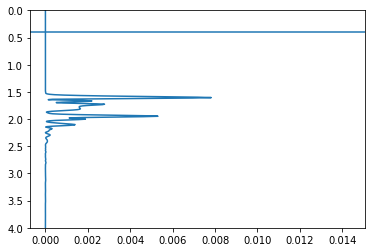

In [ ]:
plt.plot(test.ku_hh[:,0], test.ku_rg[:,0])
plt.axhline(mag.iloc[index].DepthCm/100)
plt.ylim(4,0)

For this plot to be meaningful would have to add the height of the magnaprobe above ground - is this altitudeB in the csv? From looking at the values I don't think that's right

(4.0, 0.0)

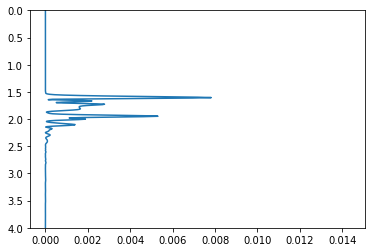

In [ ]:
plt.plot(test.ku_hh[:,0], test.ku_rg[:,0])
plt.axhline(mag.iloc[index].DepthCm/100+mag.iloc[index].altitudeB)
plt.ylim(4,0)

In [ ]:
from scipy.spatial import distance
#compare with above
def closest_point(point, points):
    closest_index = distance.cdist([point], points).argmin()
    return points[closest_index]

print(ku_loc.iloc[1000], closest_point(ku_loc.iloc[1000], np.transpose(mag_loc)))

x    486.132533
y   -133.008430
Name: 1000, dtype: float64 [ 484.98314708 -130.4318741 ]


This returns the same result as my code above. Looking at the x, y coordinates of the two points they seem to not be close together at all.

In [ ]:
closest_points_list = []
mag_tp = np.transpose(mag_loc)
for i in range(len(ku_loc)):
  cp = closest_point(ku_loc.iloc[i], mag_tp)
  closest_points_list.append(cp)

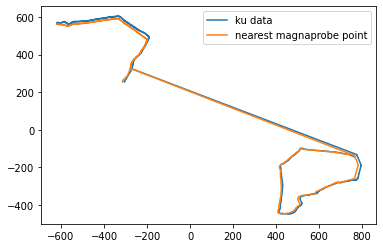

In [ ]:
cp_array = np.vstack(closest_points_list)
plt.plot(ku_loc.x, ku_loc.y, label='ku data')
plt.plot(cp_array[:,0], cp_array[:,1], label = 'nearest magnaprobe point')
plt.legend()

So it looks the magnaprobe file I am looking at has the closest points for the top left part only. Select the last 4000 points to look at this bit.

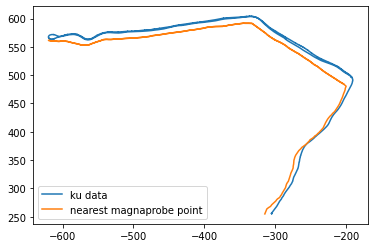

In [ ]:
plt.plot(ku_loc.x[4000:,], ku_loc.y[4000:,], label='ku data')
plt.plot(cp_array[4000:,0], cp_array[4000:,1], label = 'nearest magnaprobe point')
plt.legend()

In [ ]:
def closest_point(point, magna_points):
    magna_locations = (magna_points.xc, magna_points.yc)
    magna_locations = (np.transpose(magna_locations))
    closest_index = distance.cdist([point], magna_locations).argmin()
    #result = np.count_nonzero(dist_matrix<=r)
    return magna_points.iloc[closest_index]

closest_points_list = []

for i in range(len(ku_loc)):
  cp = closest_point(ku_loc.iloc[i], mag)
  closest_points_list.append(cp)

cp_array = np.vstack(closest_points_list)

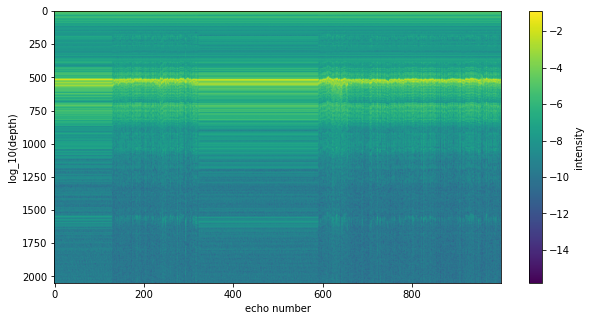

In [ ]:
sliced_array = test.ku_hh[:,4000:5000]
#fig, ax = plt.subplots(figsze = (10,10)
#plt.yscale("log") #changed to plt from ax because yscale doesn't work otherwise?
plt.figure(figsize = (10,5))
plt.imshow(np.log10(sliced_array), aspect= 'auto')
plt.xlabel('echo number')
plt.ylabel('log_10(depth)')
cbar = plt.colorbar() 
cbar.set_label('intensity',size=10)
#ax.plot(x, x, '--', linewidth=5, color='firebrick') #use this to eventually plot magnaprobe data over img

I'm not sure how to plot the echoes along here with imshow so I can plot magnaprobe depth over it.

## methods to evaluate how well the radar data matches magnaprobe data
* magnaprobe snow depth vs radar maximum/first maximum/second maximum?
* could compare these initially with something simple like a $\chi^2$ evaluation
* does the width of the power spectrum affect how well it fits?


## bits of code cut from elsewhere

In [ ]:
#find a way to match magnaprobe data with corresponding kuka data
#compare the two
#either: NN or other simpler parametrisations-does depth correspond to first peak etc 
#how does peak width impact accuracy- does it?

In [ ]:
# cut code 

#if (mag.lon == test.ka_lon):

#fig, ax = plt.subplots()
#ax.imshow(control.mag2db(test.ku_hh), aspect='auto') #, extent=[0, 400, 0, 300]
#ax.plot(test.ku_hh[:,0], test.ku_rg[:,0])
#ax.plot(np.arange(min(test.ku_hh[:,0]), max(test.ku_hh[:,0]), 1/len(mag.DepthCm))(mag.DepthCm), '--', color='firebrick')

#for magnafile in magna_files:
#   if (magnafile.lon == testobj.ka_lon) and (magnafile.lat == testobj.ka_lat):
#    plt.plot

#def mfiles(self): #magnaprobe data files
#        mfile_path = '/content/drive/My Drive/msci_project/magna_xy/'
#        mf = fnmatch.filter(os.listdir(mfile_path),'*'+self.date+'*') #magnaprobe files 
#
#        print(len(mf))
        
#        for m in mf: 
#            print('magnaprobe file: ', m)
            #check which probe was used
#            with open(mfile_path+m) as f:
#                first_line = f.readline()
#            if first_line.find('Anja') > 0:   #Anja is at UTC
#                hdelta = 0
#                print('Anja probe, hdelta = ',hdelta)
#            elif m.find('Anja') > 0:  #katrin is 6 hours behind UTC
#                hdelta = 0
#                print('Anja probe, hdelta = ',hdelta)
#            elif first_line.find('Katrin') > 0:  #katrin is 6 hours behind UTC
#                hdelta = 6
#                print('Katrin probe, hdelta = ',hdelta)
#            elif m.find('Katrin') > 0:  #katrin is 6 hours behind UTC
#                hdelta = 6
#                print('Katrin probe, hdelta = ',hdelta)
#            else:
#                print('MAGNAPROBE NAME NOT KNOWN')
#            
#            mag = pd.read_csv(mfile_path+m, delimiter = ',', 
#                    names = ["TIMESTAMP","RECORD","Counter","DepthCm","BattVolts",
#                           "latitude_a","latitude_b","Longitude_a","Longitude_b",
#                           "fix_quality","nmbr_satellites","HDOP","altitudeB",
#                           "DepthVolts","LatitudeDDDDD","LongitudeDDDDD",
#                           "month","dayofmonth","hourofday","minutes","seconds",
#                           "microseconds"],skipinitialspace = True, skiprows = 4)
#            
#            mag_month = np.array(mag.month) 
#            mag_dayofmonth = np.array(mag.dayofmonth) 
#            mag_hourofday = np.array(mag.hourofday) 
#            mag_minutes = np.array(mag.minutes) 
#            mag_seconds = np.array(mag.seconds)
#            year = [int(sub[0:4]) for sub in mag.TIMESTAMP]
#            magna_dts=np.zeros(len(year))
#                        
#            for d in range(len(year)):
#
#                t = datetime.datetime(year[d],mag_month[d],mag_dayofmonth[d],
#                                                 int(mag_hourofday[d]), int(mag_minutes[d]), 
#                                                 int(mag_seconds[d]))
#    
#                t = t + datetime.timedelta(hours = hdelta)
#
#                magna_dts[d] = (t - datetime.datetime(1970,1,1)).total_seconds()
#            if m == mf[0]:
#                lon = np.array((mag.Longitude_a + mag.Longitude_b/60.))
#                lat = np.array((mag.latitude_a + mag.latitude_b/60.))
#                depth = mag.DepthCm/100.
#                 print('depth.shape',depth.shape)
#                timestamp = mag.TIMESTAMP
#                dts = magna_dts
#            else:
#                lon = np.hstack((lon,mag.Longitude_a + mag.Longitude_b/60.))
#                lat = np.hstack((lat,np.array((mag.latitude_a + mag.latitude_b/60.))))
#                depth = np.hstack((depth,mag.DepthCm/100.))
#                 print('depth.shape',depth.shape)


#                timestamp = np.hstack((timestamp,mag.TIMESTAMP))
#                dts = np.hstack((dts,magna_dts))
#
#        self.magna_dts = dts
#        self.magna_lat = lat
#        self.magna_lon = lon
#        self.magna_depth = depth
#        self.magna_timestamp = timestamp